In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [4]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [5]:
df = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/creditcard.csv')

In [6]:
df.shape

(284807, 31)

In [7]:
df.isnull().values.any()

False

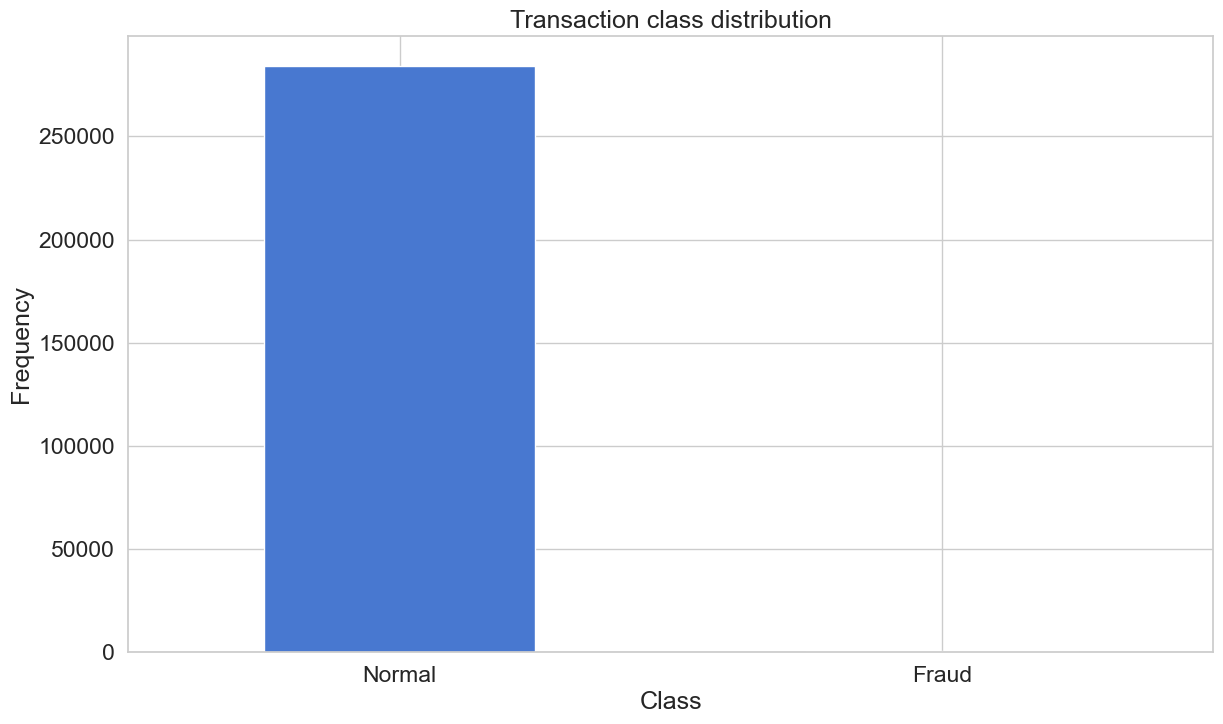

In [8]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [10]:
normal.shape

(284315, 31)

In [11]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

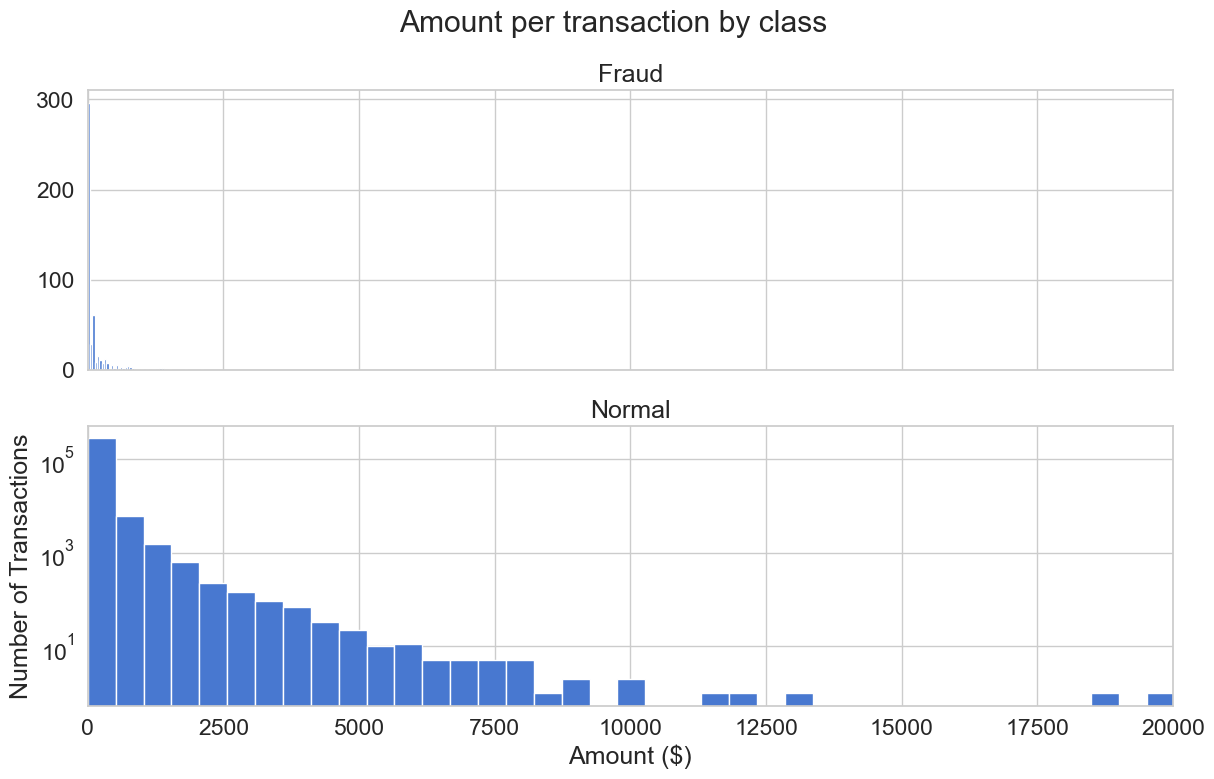

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

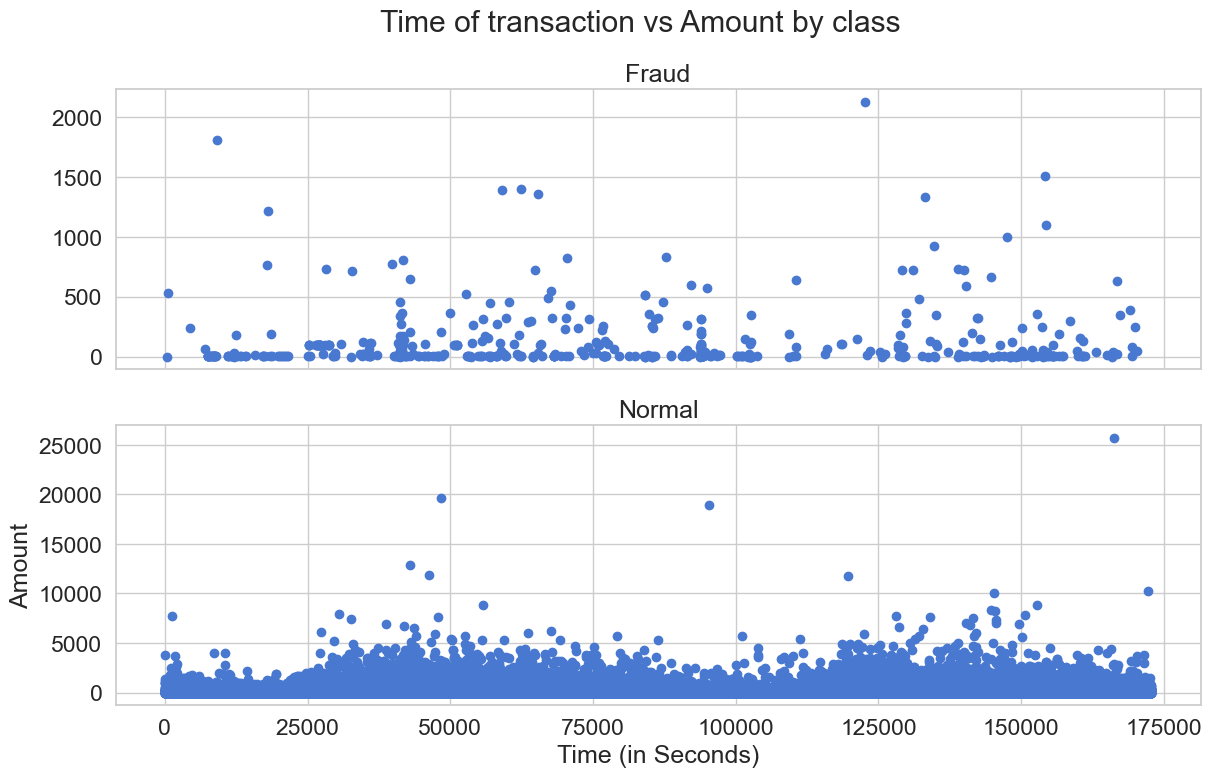

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


In [15]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [16]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_train_noisy.shape

(181960, 29)

In [17]:
input_dim = X_train_noisy.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [18]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h4",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
5685/5687 [============================>.] - ETA: 0s - loss: 0.8140 - accuracy: 0.5732

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 35s 6ms/step - loss: 0.8139 - accuracy: 0.5732 - val_loss: 0.7818 - val_accuracy: 0.6378
Epoch 2/10
5681/5687 [============================>.] - ETA: 0s - loss: 0.7433 - accuracy: 0.6622

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 31s 6ms/step - loss: 0.7431 - accuracy: 0.6622 - val_loss: 0.7651 - val_accuracy: 0.6722
Epoch 3/10
5674/5687 [============================>.] - ETA: 0s - loss: 0.7324 - accuracy: 0.6794

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 32s 6ms/step - loss: 0.7324 - accuracy: 0.6794 - val_loss: 0.7592 - val_accuracy: 0.6841
Epoch 4/10
5684/5687 [============================>.] - ETA: 0s - loss: 0.7281 - accuracy: 0.6862

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 32s 6ms/step - loss: 0.7280 - accuracy: 0.6862 - val_loss: 0.7554 - val_accuracy: 0.6875
Epoch 5/10
5681/5687 [============================>.] - ETA: 0s - loss: 0.7254 - accuracy: 0.6906

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 30s 5ms/step - loss: 0.7254 - accuracy: 0.6907 - val_loss: 0.7524 - val_accuracy: 0.6943
Epoch 6/10
5685/5687 [============================>.] - ETA: 0s - loss: 0.7219 - accuracy: 0.6924

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 30s 5ms/step - loss: 0.7218 - accuracy: 0.6924 - val_loss: 0.7506 - val_accuracy: 0.6859
Epoch 7/10
5684/5687 [============================>.] - ETA: 0s - loss: 0.7192 - accuracy: 0.6905

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 31s 5ms/step - loss: 0.7191 - accuracy: 0.6905 - val_loss: 0.7456 - val_accuracy: 0.6947
Epoch 8/10
5683/5687 [============================>.] - ETA: 0s - loss: 0.7168 - accuracy: 0.6900

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 33s 6ms/step - loss: 0.7168 - accuracy: 0.6900 - val_loss: 0.7453 - val_accuracy: 0.6854
Epoch 9/10
5682/5687 [============================>.] - ETA: 0s - loss: 0.7146 - accuracy: 0.6905

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 32s 6ms/step - loss: 0.7144 - accuracy: 0.6905 - val_loss: 0.7427 - val_accuracy: 0.6912
Epoch 10/10
5677/5687 [============================>.] - ETA: 0s - loss: 0.7124 - accuracy: 0.6895

INFO:tensorflow:Assets written to: model.h4\assets


INFO:tensorflow:Assets written to: model.h4\assets


5687/5687 [==============================] - 31s 6ms/step - loss: 0.7126 - accuracy: 0.6895 - val_loss: 0.7393 - val_accuracy: 0.6895


In [19]:
autoencoder = load_model('model.h4')

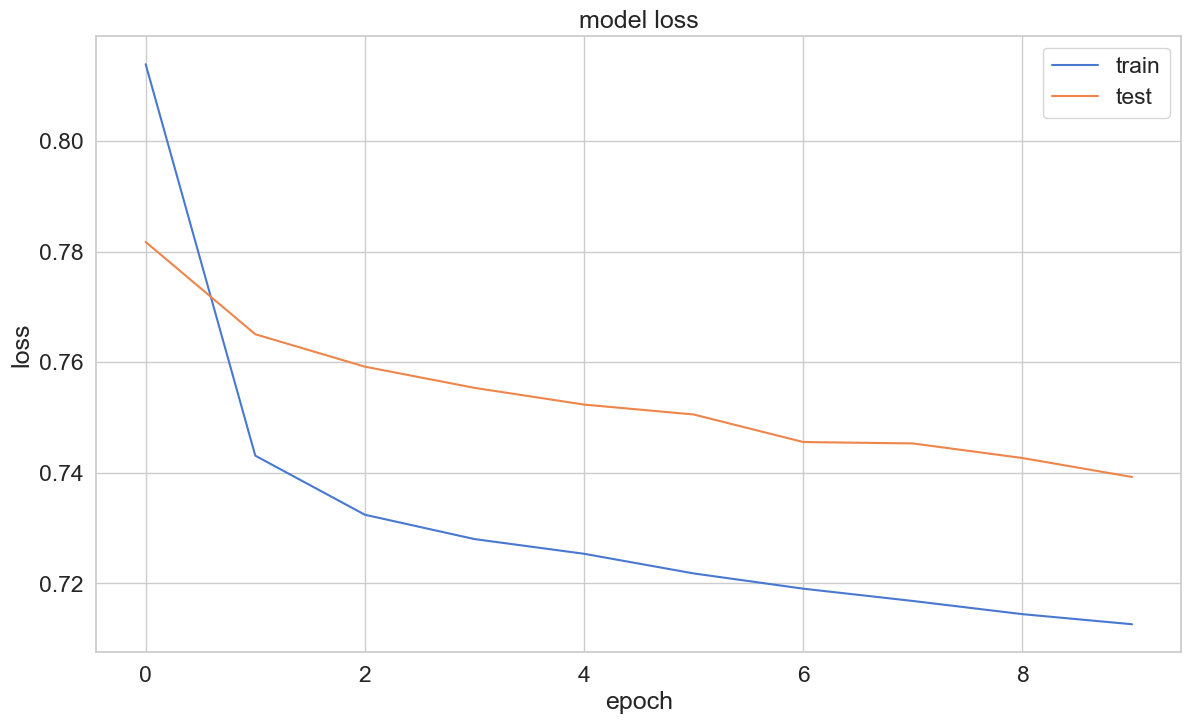

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [21]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 [==============================] - 6s 3ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.751437,0.001720
std,3.539137,0.041443
min,0.046848,0.000000
25%,0.247633,0.000000
50%,0.394106,0.000000
75%,0.621977,0.000000
max,266.648336,1.000000


[ 정상 거래 데이터 오류 분포 ]

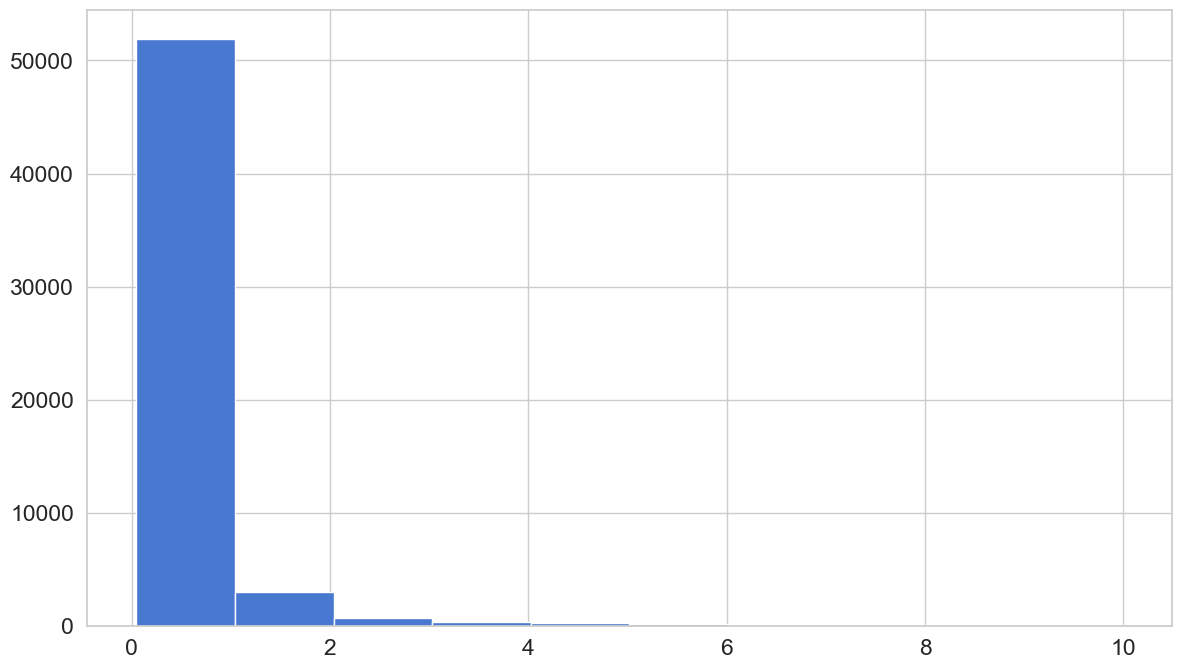

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

[ 이상 거래 데이터 오류 분포 ]

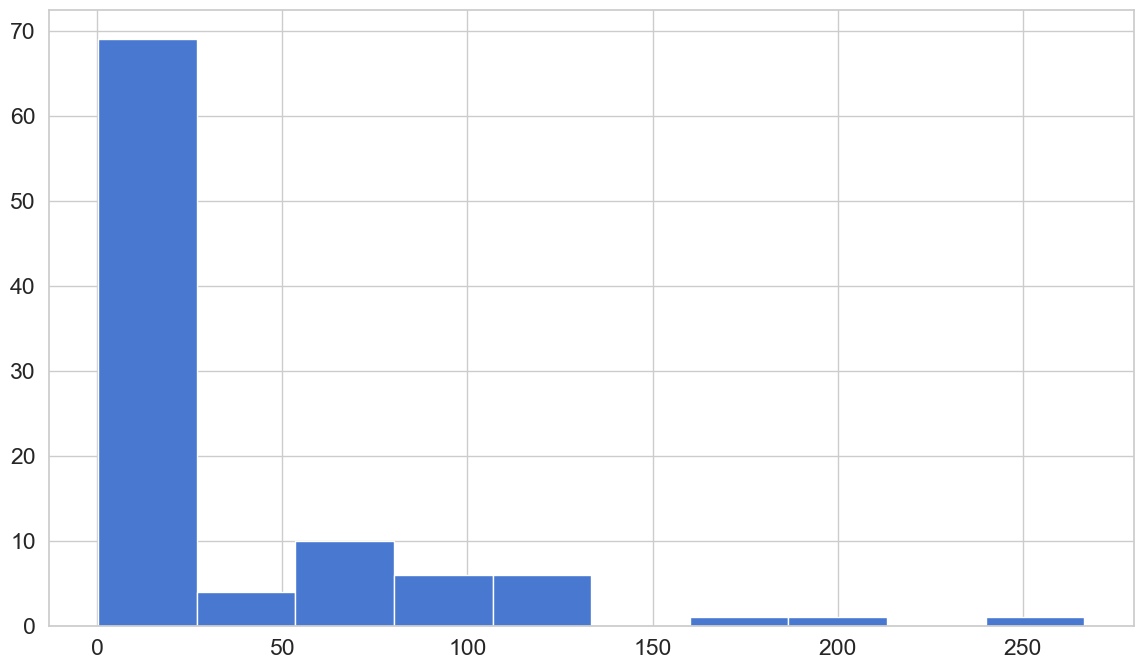

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

[ RCO 평가 ]

In [24]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

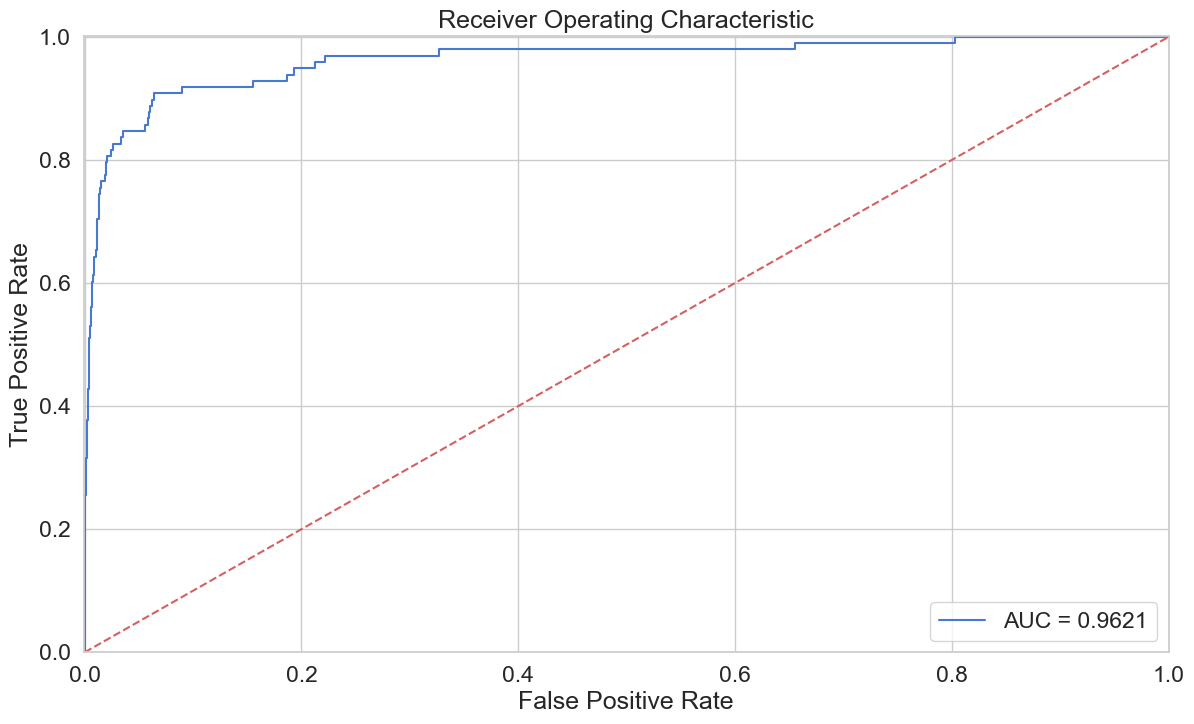

In [25]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

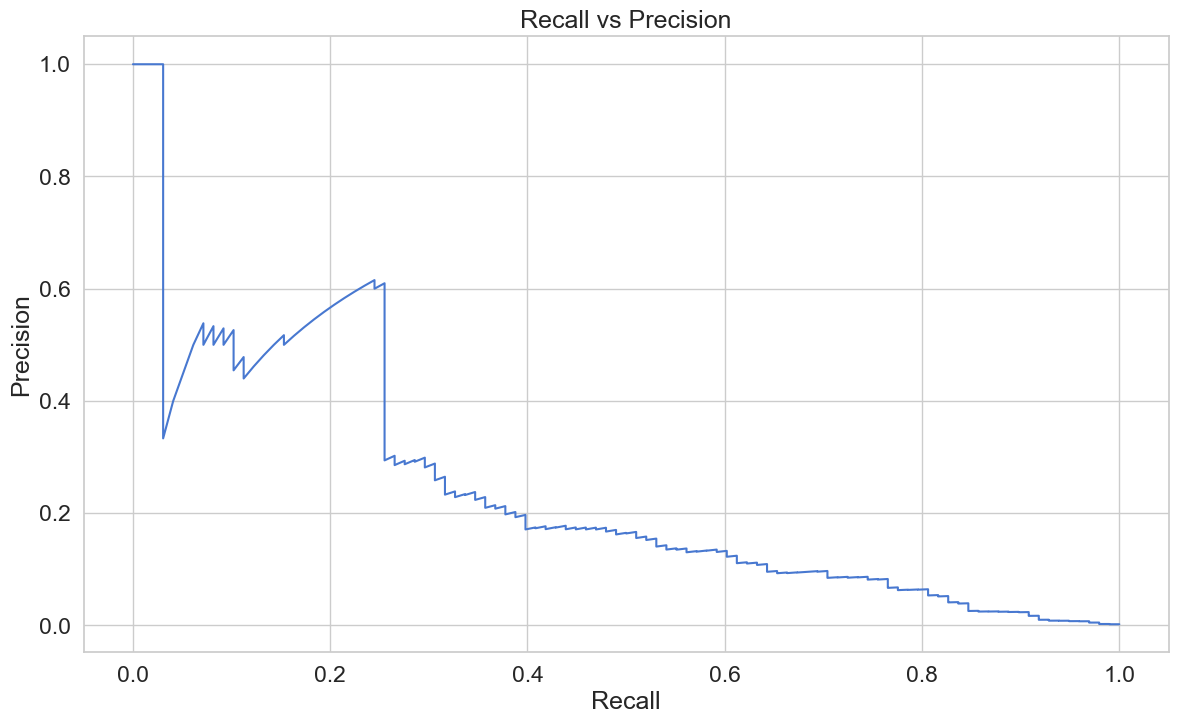

In [26]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

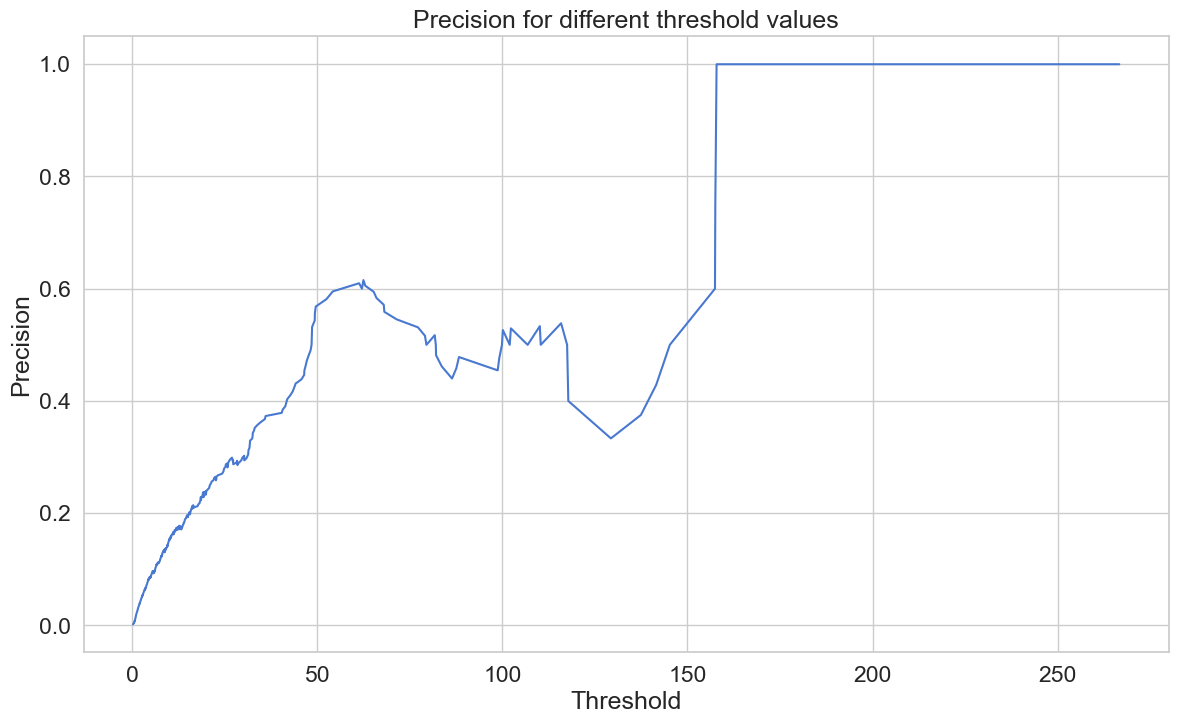

In [27]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

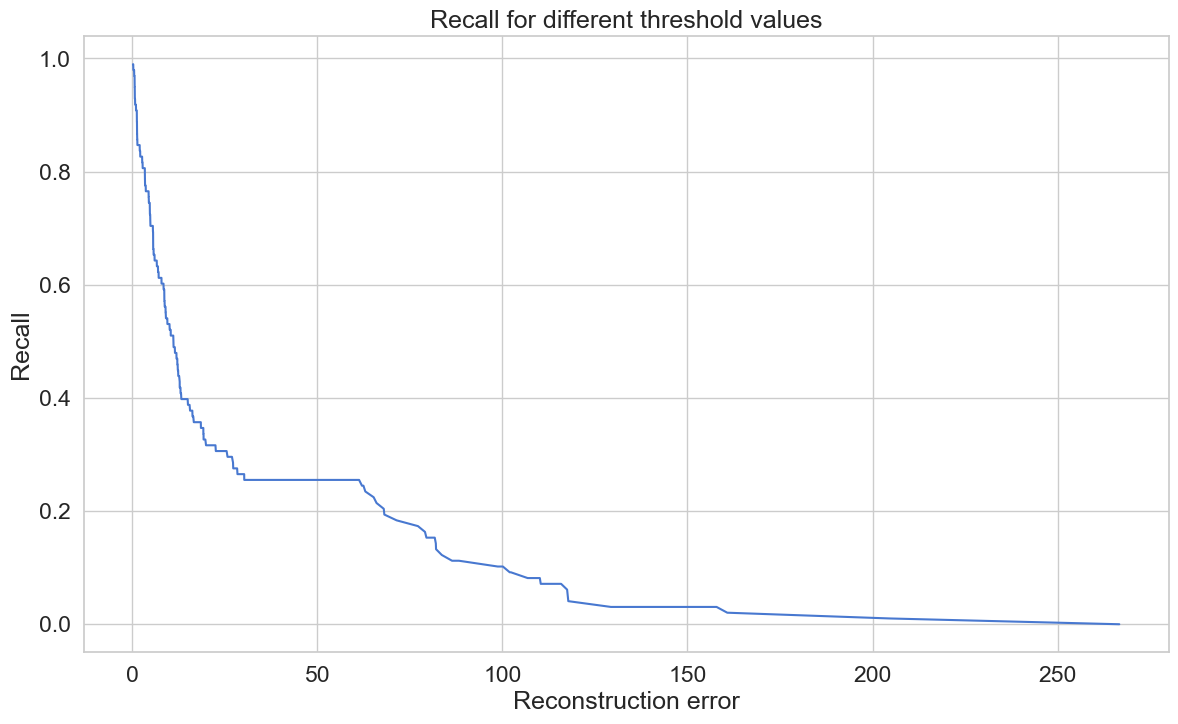

In [28]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [29]:
threshold = 2.9

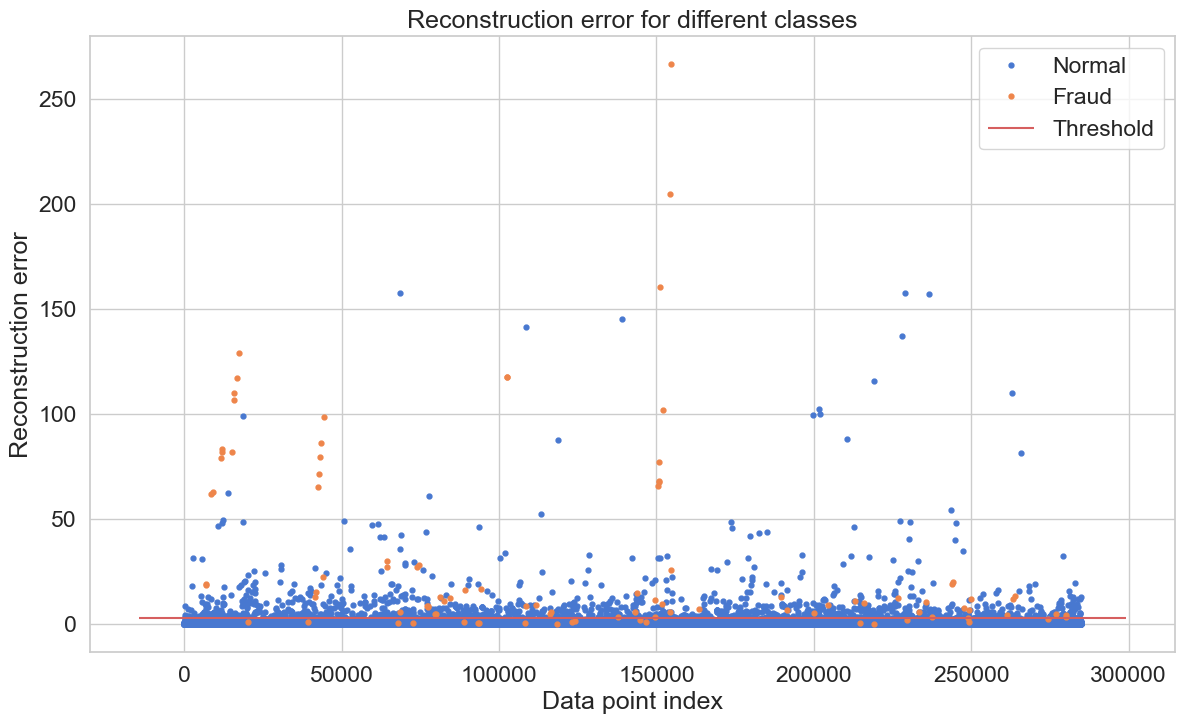

In [30]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

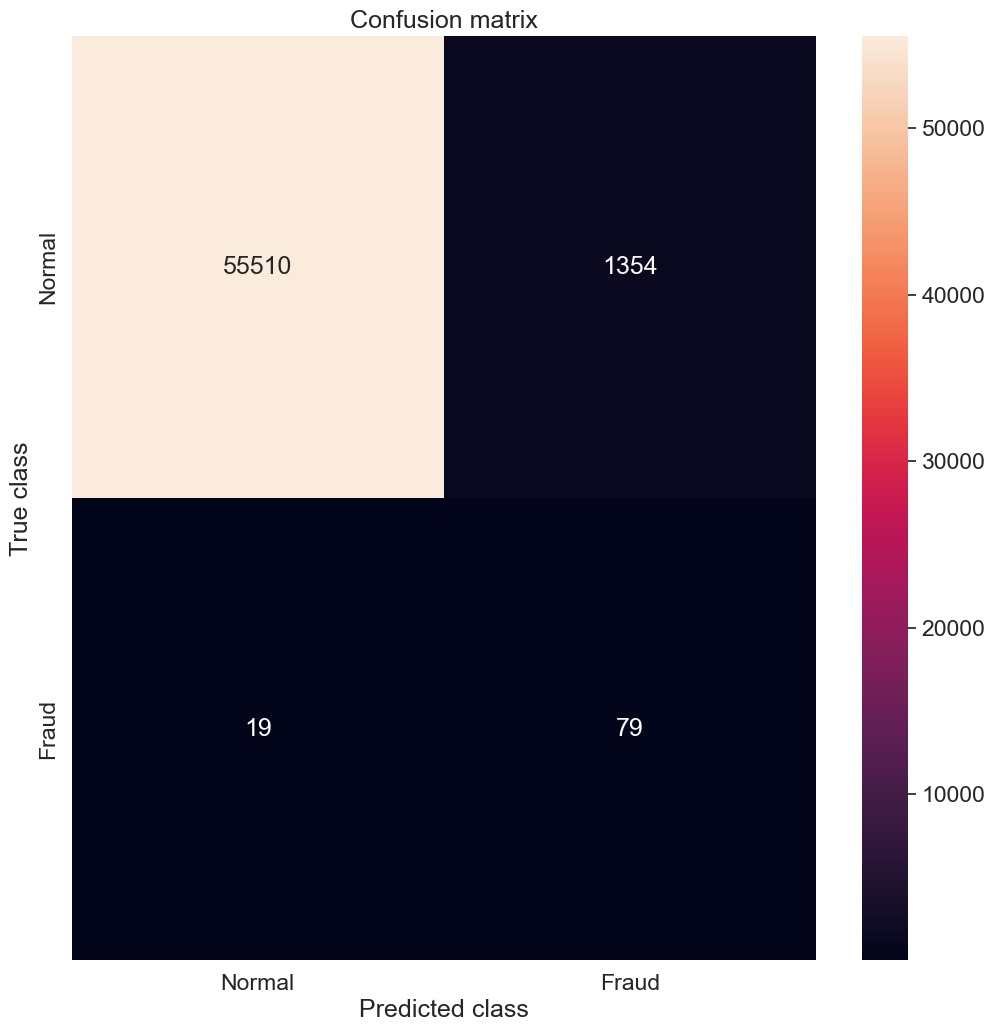

In [31]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()